<a href="https://colab.research.google.com/github/aslyldrm/Temporal-Link-Prediction-Using-Graph-Neural-Networks-PyTorch-Geometric-Temporal/blob/main/TGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 17.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
node_features = pd.read_csv("/content/drive/MyDrive/sertifikalarım/Social_Network/node_features.csv.gz",names=['node_id', "feat_0", 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7'],header=None)
edge_features = pd.read_csv("/content/drive/MyDrive/sertifikalarım/Social_Network/edge_type_features.csv.gz",names=['edge_type_id', "feat_0", 'feat_1', 'feat_2',],header=None)
test_data = pd.read_csv("/content/drive/MyDrive/sertifikalarım/Social_Network/input_A.csv.gz",names=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time'],header=None)
edges_train = pd.read_csv('/content/drive/MyDrive/sertifikalarım/Social_Network/edges_train_A.csv.gz',names=['src_id', 'dst_id', 'edge_type', 'timestamp'],header=None)



In [ ]:
test_data

,src_id,dst_id,edge_type,start_time,end_time
0,19,2867,4,1498693690,1498840508
1,19,2880,8,1496420943,1496640465
2,19,3990,20,1496308468,1496472407
3,19,5186,234,1496438901,1496571525
4,19,6486,108,1496294861,1496462528
...,...,...,...,...,...
199995,69980,49214,176,1494875670,1494996140
199996,69980,52874,33,1498584288,1498694102
199997,69980,55746,209,1497952740,1498081488
199998,69980,60642,71,1497166072,1497356374


In [ ]:
edge_features

,edge_type_id,feat_0,feat_1,feat_2
0,0,56,16,32
1,1,179,15,70
2,2,65,6,62
3,3,104,12,86
4,4,114,3,20
...,...,...,...,...
243,243,196,17,98
244,244,21,15,70
245,245,92,10,26
246,246,1,1,109


In [ ]:
node_features

,node_id,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7
0,2,29,-1,-1,-1,-1,9,-1,-1
1,5,29,-1,-1,-1,-1,-1,-1,20
2,11,11,-1,-1,-1,-1,-1,-1,20
3,16,13,-1,-1,-1,-1,155,-1,20
4,19,-1,-1,-1,-1,-1,40,-1,-1
...,...,...,...,...,...,...,...,...,...
19437,69967,29,-1,-1,-1,-1,86,-1,20
19438,69971,0,-1,-1,-1,-1,-1,-1,20
19439,69973,29,-1,-1,-1,-1,37,-1,-1
19440,69980,29,-1,-1,-1,-1,59,-1,-1


In [ ]:
unique_nodes = pd.concat([
    edges_train['src_id'],
    edges_train['dst_id'],
    test_data['src_id'],
    test_data['dst_id'],
    node_features['node_id']
]).unique()
print("NaN values in test_data dst_id:", node_features['node_id'].isna().sum())

node_id_map = {node_id: i for i, node_id in enumerate(sorted(unique_nodes))}

edges_train['src_id'] = edges_train['src_id'].map(node_id_map)
edges_train['dst_id'] = edges_train['dst_id'].map(node_id_map)
node_features['node_id'] = node_features['node_id'].map(node_id_map)
test_data['src_id'] = test_data['src_id'].map(node_id_map)
test_data['dst_id'] = test_data['dst_id'].map(node_id_map)

num_time_bins = 24
edges_train['time_bin'] = pd.cut(edges_train['timestamp'], bins=num_time_bins, labels=False)

NaN values in test_data dst_id: 0


In [ ]:
print("NaN values in test_data src_id:", test_data['src_id'].isna().sum())
print("NaN values in test_data dst_id:", test_data['dst_id'].isna().sum())

NaN values in test_data src_id: 0
NaN values in test_data dst_id: 0
NaN values in test_data dst_id: 0


In [ ]:
num_time_bins = 24
edges_train['time_bin'] = pd.cut(edges_train['timestamp'], bins=num_time_bins, labels=False)

time_bin_edges = pd.cut(edges_train['timestamp'], bins=num_time_bins, retbins=True)[1]

test_data['start_bin'] = pd.cut(test_data['start_time'], bins=time_bin_edges, labels=False)
test_data['end_bin'] = pd.cut(test_data['end_time'], bins=time_bin_edges, labels=False)

test_data['start_bin'] = test_data['start_bin'].fillna(0).astype(int)
test_data['end_bin'] = test_data['end_bin'].fillna(num_time_bins-1).astype(int)

snapshots = []
for time_bin in range(num_time_bins):
    edges_in_bin = edges_train[edges_train['time_bin'] == time_bin]

    if len(edges_in_bin) == 0:
        continue

    src_nodes = edges_in_bin['src_id'].values
    dst_nodes = edges_in_bin['dst_id'].values

    all_src = np.concatenate([src_nodes, dst_nodes])
    all_dst = np.concatenate([dst_nodes, src_nodes])

    edge_index = torch.tensor(
        np.array([all_src, all_dst]),
        dtype=torch.long
    )

    edge_attr_values = None
    try:
        edge_attr_values = edge_features.loc[edges_in_bin.index].drop('edge_type_id', axis=1).values
        edge_attr = torch.tensor(
            np.concatenate([edge_attr_values, edge_attr_values]),
            dtype=torch.float
        )
    except:
        edge_attr = torch.zeros(len(all_src), edge_features.shape[1]-1)



node_feats = torch.zeros(len(node_id_map), node_features.shape[1]-1)
node_feats[node_features['node_id']] = torch.tensor(
    node_features.drop('node_id', axis=1).values,
    dtype=torch.float
)


In [ ]:
test_data

,src_id,dst_id,edge_type,start_time,end_time,start_bin,end_bin
0,4,799,4,1498693690,1498840508,0,23
1,4,803,8,1496420943,1496640465,0,23
2,4,1132,20,1496308468,1496472407,0,23
3,4,1456,234,1496438901,1496571525,0,23
4,4,1813,108,1496294861,1496462528,0,23
...,...,...,...,...,...,...,...
199995,19440,13632,176,1494875670,1494996140,0,23
199996,19440,14635,33,1498584288,1498694102,0,23
199997,19440,15424,209,1497952740,1498081488,0,23
199998,19440,16756,71,1497166072,1497356374,0,23


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

Creating raw graph visualization from 27045268 edges
Graph with 500 nodes and 664 edges


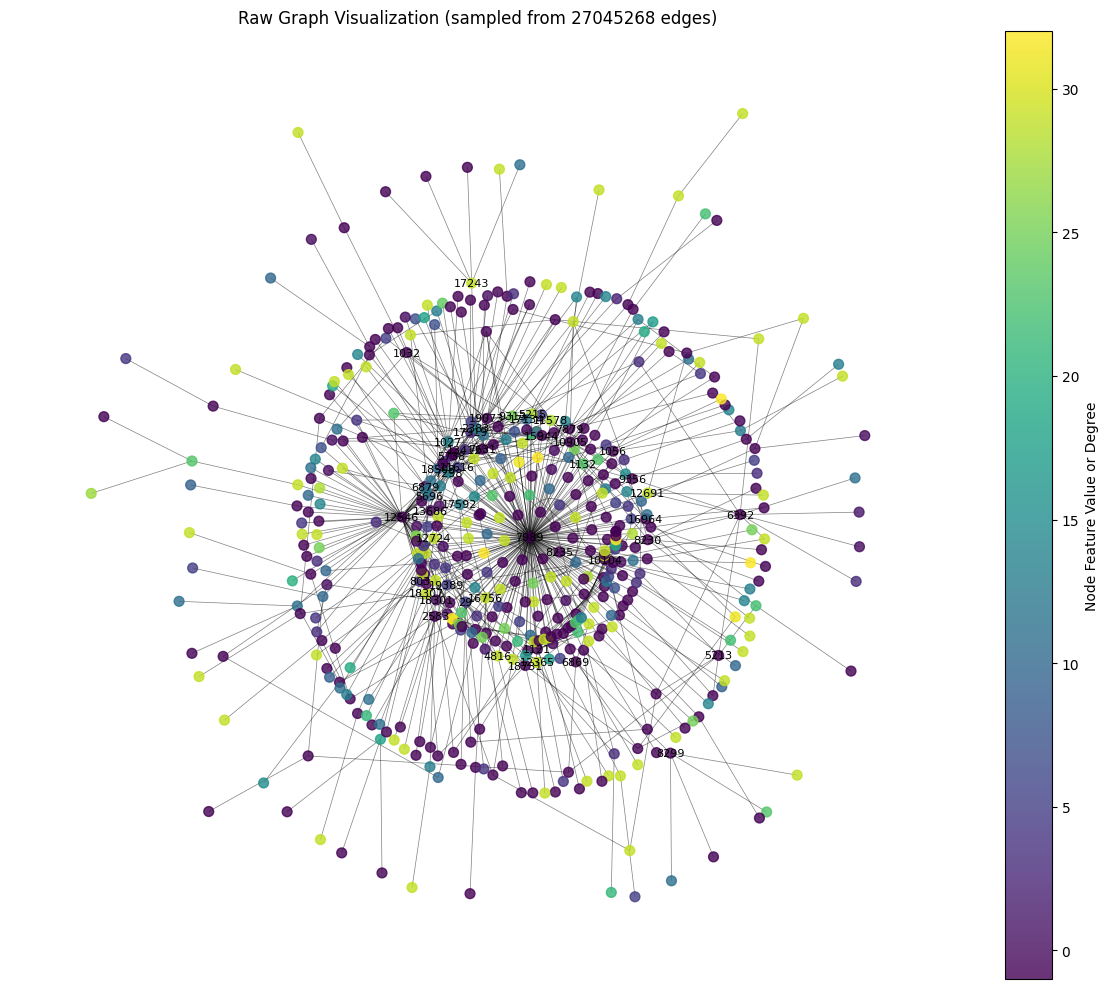

Graph Statistics:
Number of nodes: 500
Number of edges: 664
Average degree: 2.66
Density: 0.005323
Average clustering coefficient: 0.0937
Number of connected components: 34


In [ ]:
def visualize_raw_graph(edges_df, node_features=None, max_nodes=1000, sample_edges=True):
    print(f"Creating raw graph visualization from {len(edges_df)} edges")

    G = nx.Graph()

    if sample_edges and len(edges_df) > max_nodes * 2:
        sampled_edges = edges_df.sample(max_nodes * 2)
    else:
        sampled_edges = edges_df


    for _, row in sampled_edges.iterrows():
        G.add_edge(row['src_id'], row['dst_id'])

    if len(G.nodes()) > max_nodes:
        degrees = dict(G.degree())
        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        nodes_to_keep = [node for node, _ in top_nodes]
        G = G.subgraph(nodes_to_keep)

    print(f"Graph with {len(G.nodes())} nodes and {len(G.edges())} edges")

    plt.figure(figsize=(12, 10))

    if len(G.nodes()) < 100:
        pos = nx.spring_layout(G, seed=42)
    else:
        pos = nx.kamada_kawai_layout(G)

    node_colors = []
    if node_features is not None:
        feature_col = 'feat_0'
        for node in G.nodes():
            if node in node_features['node_id'].values:
                idx = node_features[node_features['node_id'] == node].index[0]
                node_colors.append(node_features.loc[idx, feature_col])
            else:
                node_colors.append(0)
    else:
        node_colors = [G.degree(node) for node in G.nodes()]

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        node_size=50,
        alpha=0.8
    )

    edges = nx.draw_networkx_edges(
        G, pos,
        width=0.5,
        alpha=0.5
    )


    if len(G.nodes()) < 50:
        nx.draw_networkx_labels(G, pos, font_size=8)
    else:

        degrees = dict(G.degree())
        top_nodes = {node: node for node, degree in degrees.items()
                    if degree > np.percentile(list(degrees.values()), 90)}
        nx.draw_networkx_labels(G, pos, labels=top_nodes, font_size=8)

    plt.colorbar(nodes, label="Node Feature Value or Degree")
    plt.title(f"Raw Graph Visualization (sampled from {len(edges_df)} edges)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Graph Statistics:")
    print(f"Number of nodes: {len(G.nodes())}")
    print(f"Number of edges: {len(G.edges())}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / len(G.nodes()):.2f}")
    print(f"Density: {nx.density(G):.6f}")

    try:
        if len(G.nodes()) < 1000:
            print(f"Average clustering coefficient: {nx.average_clustering(G):.4f}")
            print(f"Number of connected components: {nx.number_connected_components(G)}")
    except:
        print("Graph metrics couldn't be computed because of graph size")

visualize_raw_graph(edges_train, node_features, max_nodes=500)

In [ ]:
def temporal_negative_sampling_pyg(edge_index, num_nodes, timestamps=None, num_neg_samples=None):
    if num_neg_samples is None:
        neg_edge_index = negative_sampling(edge_index, num_nodes=num_nodes,method='sparse')
    else:
        neg_edge_index = negative_sampling(
            edge_index,
            num_nodes=num_nodes,
            num_neg_samples=num_neg_samples,
            method='sparse'

        )

    if timestamps is not None and len(timestamps) > 0:

        try:
            current_time = timestamps.max()
            if hasattr(timestamps, 'shape') and len(timestamps) == edge_index.shape[1]:
                future_mask = (timestamps[neg_edge_index[0]] > current_time) | (timestamps[neg_edge_index[1]] > current_time)
                neg_edge_index = neg_edge_index[:, ~future_mask]
        except:
            pass

    return neg_edge_index

In [ ]:
def visualize_embeddings(model, batch, node_feats, title="Embedding Visualization"):
    model.eval()

    with torch.no_grad():
        node_embeddings = model(
            node_feats,
            batch['edge_index'],
            batch['edge_attr'],
            batch['timestamps']
        )

        src, dst = batch['edge_index']
        pos_pairs = torch.stack([node_embeddings[src], node_embeddings[dst]], dim=1)

        neg_edge_index = negative_sampling(
            edge_index=batch['edge_index'],
            num_nodes=len(node_feats),
            num_neg_samples=min(1000, len(src))
        )
        neg_src, neg_dst = neg_edge_index
        neg_pairs = torch.stack([node_embeddings[neg_src], node_embeddings[neg_dst]], dim=1)

        from sklearn.manifold import TSNE

        max_samples = 1000
        pos_sample_idx = np.random.choice(len(pos_pairs), min(max_samples, len(pos_pairs)), replace=False)
        neg_sample_idx = np.random.choice(len(neg_pairs), min(max_samples, len(neg_pairs)), replace=False)

        pos_pairs_sample = pos_pairs[pos_sample_idx].reshape(-1, node_embeddings.shape[1])
        neg_pairs_sample = neg_pairs[neg_sample_idx].reshape(-1, node_embeddings.shape[1])

        combined_pairs = torch.cat([pos_pairs_sample, neg_pairs_sample], dim=0)
        pair_labels = torch.cat([
            torch.ones(len(pos_pairs_sample)),
            torch.zeros(len(neg_pairs_sample))
        ])

        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(combined_pairs)-1))
        embedded = tsne.fit_transform(combined_pairs.cpu().numpy())

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            embedded[:, 0],
            embedded[:, 1],
            c=pair_labels,
            cmap='coolwarm',
            alpha=0.6,
            s=50
        )

        plt.colorbar(scatter, label="Edge Exists (1) / Doesn't Exist (0)")
        plt.title(title)
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(alpha=0.3)
        plt.show()

        pos_scores = F.cosine_similarity(node_embeddings[src], node_embeddings[dst]).mean().item()
        neg_scores = F.cosine_similarity(node_embeddings[neg_src], node_embeddings[neg_dst]).mean().item()

        print(f"Average similarity for positive pairs: {pos_scores:.4f}")
        print(f"Average similarity for negative pairs: {neg_scores:.4f}")
        print(f"Separation (pos - neg): {pos_scores - neg_scores:.4f}")



In [ ]:
import math

class TimeEncoder(nn.Module):
    def __init__(self, dimension, max_time=10000):
        super(TimeEncoder, self).__init__()
        self.dimension = dimension
        self.max_time = max_time
        self.basis_freq = nn.Parameter(torch.zeros(dimension))
        self.phase = nn.Parameter(torch.zeros(dimension))

        nn.init.uniform_(self.basis_freq, 0, 0.1)
        nn.init.uniform_(self.phase, 0, 0.1)

    def forward(self, timestamps):
        if not isinstance(timestamps, torch.Tensor):
            timestamps = torch.tensor(timestamps, dtype=torch.float)

        timestamps = timestamps.unsqueeze(-1) / self.max_time

        time_encoding = torch.sin(timestamps * self.basis_freq + self.phase)
        return time_encoding

class MemoryModule(nn.Module):
    def __init__(self, num_nodes, memory_dim):
        super().__init__()
        self.num_nodes = num_nodes
        self.memory_dim = memory_dim

        self.memory = nn.Parameter(torch.zeros(num_nodes, memory_dim))
        self.last_update = nn.Parameter(torch.zeros(num_nodes), requires_grad=False)

        self.memory_updater = nn.GRUCell(memory_dim, memory_dim)

        self.msg_aggregator = nn.Linear(memory_dim, memory_dim)

        nn.init.xavier_uniform_(self.memory, gain=0.1)

    def update_memory(self, node_idxs, messages, timestamps):

        current_memory = self.memory[node_idxs]

        updated_memory = self.memory_updater(messages, current_memory)

        new_memory = self.memory.clone()
        new_memory[node_idxs] = updated_memory
        self.memory = new_memory

        new_last_update = self.last_update.clone()
        new_last_update[node_idxs] = timestamps
        self.last_update = new_last_update

        return updated_memory

    def get_memory(self, node_idxs=None):
        if node_idxs is None:
            return self.memory
        return self.memory[node_idxs]

class MessageFunction(nn.Module):
    def __init__(self, memory_dim, time_dim, edge_feat_dim):
        super(MessageFunction, self).__init__()
        self.message_proj = nn.Linear(memory_dim * 2 + time_dim + edge_feat_dim, memory_dim)

    def forward(self, src_memory, dst_memory, time_encoding, edge_feats):
        message_inputs = torch.cat([src_memory, dst_memory, time_encoding, edge_feats], dim=1)
        messages = F.relu(self.message_proj(message_inputs))
        return messages

class TGN(nn.Module):
    def __init__(self, num_nodes, node_feat_dim, edge_feat_dim, memory_dim=32, time_dim=8,
                 num_layers=2, heads=2, dropout=0.4, embedding_l2_reg=0.001):
        super(TGN, self).__init__()
        self.num_nodes = num_nodes
        self.node_feat_dim = node_feat_dim
        self.memory_dim = memory_dim
        self.time_dim = time_dim
        self.num_layers = num_layers
        self.heads = heads
        self.embedding_l2_reg = embedding_l2_reg
        self.reg_loss = 0.0

        self.time_encoder = TimeEncoder(time_dim)

        self.memory_module = MemoryModule(num_nodes, memory_dim)

        self.message_function = MessageFunction(memory_dim, time_dim, edge_feat_dim)

        self.node_feat_transform = nn.Linear(node_feat_dim, memory_dim)

        self.edge_feat_transform = nn.Linear(edge_feat_dim + time_dim, edge_feat_dim)

        self.gat_layers = nn.ModuleList()
        for i in range(num_layers):
            in_dim = memory_dim if i == 0 else memory_dim * heads
            self.gat_layers.append(
                GATConv(
                    in_dim, memory_dim, heads=heads,
                    edge_dim=edge_feat_dim, add_self_loops=True,
                    dropout=dropout
                )
            )

        self.final_proj = nn.Linear(memory_dim * heads, node_feat_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, node_feats, edge_index, edge_attr, timestamps):
        node_feats_transformed = F.relu(self.node_feat_transform(node_feats))

        if isinstance(timestamps, torch.Tensor) and timestamps.dim() == 1 and len(timestamps) == edge_index.size(1):
            time_encoding = self.time_encoder(timestamps)
            time_encoding_repeated = time_encoding
        else:
            time_encoding = self.time_encoder(timestamps)

            if len(timestamps) != edge_attr.size(0):
                if len(timestamps) == 1:
                    time_encoding_repeated = time_encoding.repeat(edge_attr.size(0), 1)
                else:
                    max_batch_size = 10000
                    time_encoding_repeated = []

                    for i in range(0, edge_attr.size(0), max_batch_size):
                        end_idx = min(i + max_batch_size, edge_attr.size(0))
                        batch_size = end_idx - i

                        batch_time_indices = torch.arange(i, end_idx) % len(timestamps)
                        batch_encodings = time_encoding[batch_time_indices]
                        time_encoding_repeated.append(batch_encodings)

                    time_encoding_repeated = torch.cat(time_encoding_repeated, dim=0)
            else:
                time_encoding_repeated = time_encoding

        edge_attr_with_time = torch.cat([edge_attr, time_encoding_repeated], dim=1)
        edge_attr_transformed = F.relu(self.edge_feat_transform(edge_attr_with_time))

        src, dst = edge_index

        src_memory = self.memory_module.get_memory(src)
        dst_memory = self.memory_module.get_memory(dst)

        messages = self.message_function(src_memory, dst_memory, time_encoding_repeated, edge_attr_transformed)

        timestamp_value = timestamps[0] if len(timestamps) == 1 else timestamps[0].item()
        self.memory_module.update_memory(dst, messages, timestamp_value)

        memory = self.memory_module.get_memory()
        h = node_feats_transformed + memory

        for i, gat_layer in enumerate(self.gat_layers):
            h = gat_layer(h, edge_index, edge_attr=edge_attr_transformed)
            h = self.dropout(h)
            if i < self.num_layers - 1:
                h = F.relu(h)

        h = self.final_proj(h)

        embedding_norm = torch.norm(h, p=2, dim=1).mean()
        self.reg_loss = self.embedding_l2_reg * embedding_norm

        return h

In [ ]:
def create_temporal_batches_for_tgn(edges_train, node_feats, edge_features, batch_size=10000):
    edges_sorted = edges_train.sort_values('timestamp')

    batches = []

    for i in range(0, len(edges_sorted), batch_size):
        end_idx = min(i + batch_size, len(edges_sorted))
        batch_edges = edges_sorted.iloc[i:end_idx]

        src_nodes = batch_edges['src_id'].values
        dst_nodes = batch_edges['dst_id'].values

        edge_index = torch.tensor(
            np.array([src_nodes, dst_nodes]),
            dtype=torch.long
        )

        try:
            edge_attr_values = edge_features.loc[batch_edges.index].drop('edge_type_id', axis=1).values
            edge_attr = torch.tensor(edge_attr_values, dtype=torch.float)
        except:
            edge_attr = torch.zeros(len(src_nodes), edge_features.shape[1]-1)

        timestamps = torch.tensor(batch_edges['timestamp'].values, dtype=torch.float)

        batches.append({
            'edge_index': edge_index,
            'edge_attr': edge_attr,
            'timestamps': timestamps,
            'batch_edges': batch_edges
        })

    return batches

In [ ]:
temporal_batches = create_temporal_batches_for_tgn(edges_train, node_feats, edge_features, batch_size=10000)

In [ ]:
model = TGN(
    num_nodes=len(node_id_map),
    node_feat_dim=8,
    edge_feat_dim=edge_features.shape[1]-1,
    memory_dim=48,
    time_dim=12,
    num_layers=2,
    heads=2,
    dropout=0.4,
    embedding_l2_reg=0.002
)


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-05
)

In [ ]:
from torch_geometric.utils import negative_sampling

Epoch 001 | Loss: 0.5344 | Accuracy: 0.7475 | AUC: 0.9514 | Patience: 0/5
Epoch 002 | Loss: 0.5328 | Accuracy: 0.7459 | AUC: 0.9539 | Patience: 0/5
Epoch 003 | Loss: 0.5313 | Accuracy: 0.7446 | AUC: 0.9596 | Patience: 0/5
Epoch 004 | Loss: 0.5309 | Accuracy: 0.7451 | AUC: 0.9595 | Patience: 1/5
Epoch 005 | Loss: 0.5304 | Accuracy: 0.7480 | AUC: 0.9627 | Patience: 2/5
Epoch 006 | Loss: 0.5306 | Accuracy: 0.7483 | AUC: 0.9613 | Patience: 3/5
Epoch 007 | Loss: 0.5322 | Accuracy: 0.7465 | AUC: 0.9575 | Patience: 4/5
Epoch 008 | Loss: 0.5312 | Accuracy: 0.7475 | AUC: 0.9591 | Patience: 5/5

Early stopping at epoch 8!


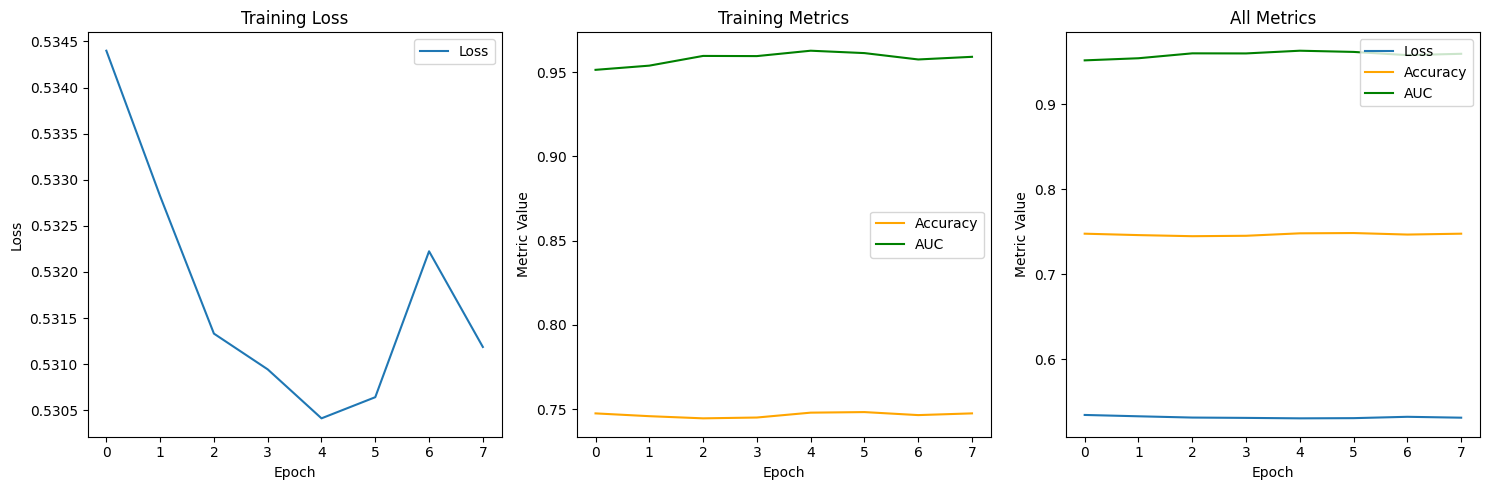

In [ ]:
train_losses = []
train_accuracies = []
train_aucs = []
best_loss = float('inf')
patience = 5
no_improve_epochs = 0
min_delta = 0.001


for epoch in range(100):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_auc = 0


    historical_edges = set()
    for batch_idx, batch in enumerate(temporal_batches):
        optimizer.zero_grad()
        model.memory_module.memory = model.memory_module.memory.detach().clone()
        model.memory_module.last_update = model.memory_module.last_update.detach().clone()
        node_embeddings = model(
            node_feats,
            batch['edge_index'],
            batch['edge_attr'],
            batch['timestamps']
        )

        src, dst = batch['edge_index']
        pos_scores = F.cosine_similarity(node_embeddings[src], node_embeddings[dst]) * 1.0

        neg_edge_index = temporal_negative_sampling_pyg(
            edge_index=batch['edge_index'],
            num_nodes=len(node_feats),
            timestamps=batch['timestamps'],
            num_neg_samples=len(src),
        )
        for s, d in zip(src.cpu().numpy(), dst.cpu().numpy()):
            historical_edges.add((s, d))

        neg_src, neg_dst = neg_edge_index
        neg_scores = F.cosine_similarity(node_embeddings[neg_src], node_embeddings[neg_dst]) * 1.0

        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])

        margin = 0.8
        contrastive_loss = torch.mean(torch.relu(margin - (pos_scores.mean() - neg_scores.mean())))


        bce_loss = F.binary_cross_entropy_with_logits(scores, labels)
        loss = bce_loss + 0.5 * model.reg_loss + contrastive_loss

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        with torch.no_grad():
            predictions = (torch.sigmoid(scores.detach()) > 0.5).float()
            accuracy = (predictions == labels).float().mean()

            from sklearn.metrics import roc_auc_score
            probs = torch.sigmoid(scores.detach()).cpu().numpy()
            y_true = labels.cpu().numpy()
            try:
                auc = roc_auc_score(y_true, probs)
            except:
                auc = 0.5

        epoch_loss += loss.item()
        epoch_acc += accuracy.item()
        epoch_auc += auc



    avg_loss = epoch_loss / len(temporal_batches)
    avg_acc = epoch_acc / len(temporal_batches)
    avg_auc = epoch_auc / len(temporal_batches)
    scheduler.step(avg_loss)

    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)
    train_aucs.append(avg_auc)

    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_tgat_model.pth')
    else:
        no_improve_epochs += 1

    print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f} | AUC: {avg_auc:.4f} | Patience: {no_improve_epochs}/{patience}")

    if no_improve_epochs >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}!")
        break

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Accuracy', color='orange')
plt.plot(train_aucs, label='AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Metrics')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy', color='orange')
plt.plot(train_aucs, label='AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('All Metrics')
plt.legend()

plt.tight_layout()
plt.show()

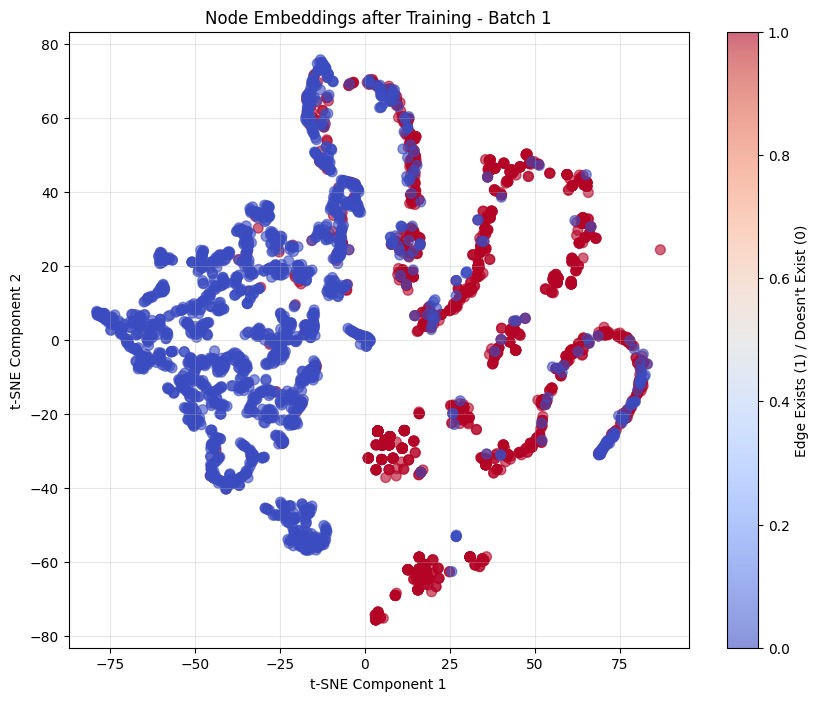

Average similarity for positive pairs: 0.9464
Average similarity for negative pairs: 0.0686
Separation (pos - neg): 0.8778


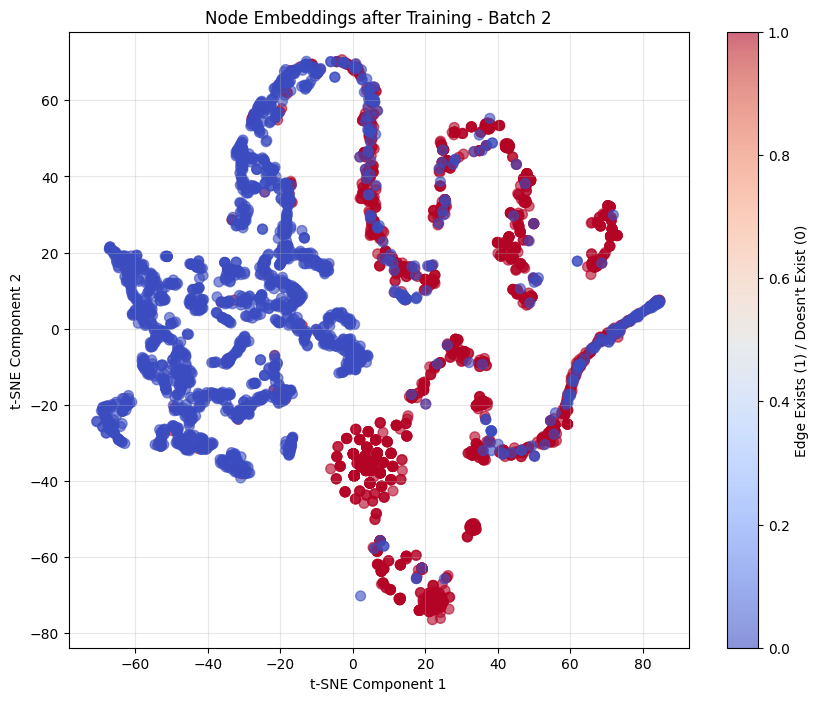

Average similarity for positive pairs: 0.9400
Average similarity for negative pairs: 0.0683
Separation (pos - neg): 0.8717


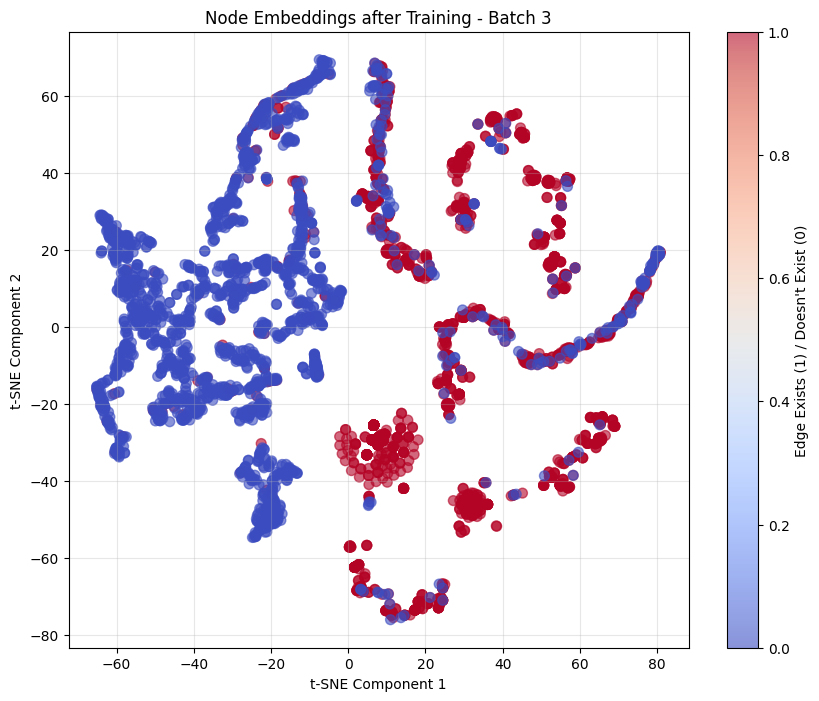

Average similarity for positive pairs: 0.9434
Average similarity for negative pairs: 0.0666
Separation (pos - neg): 0.8768


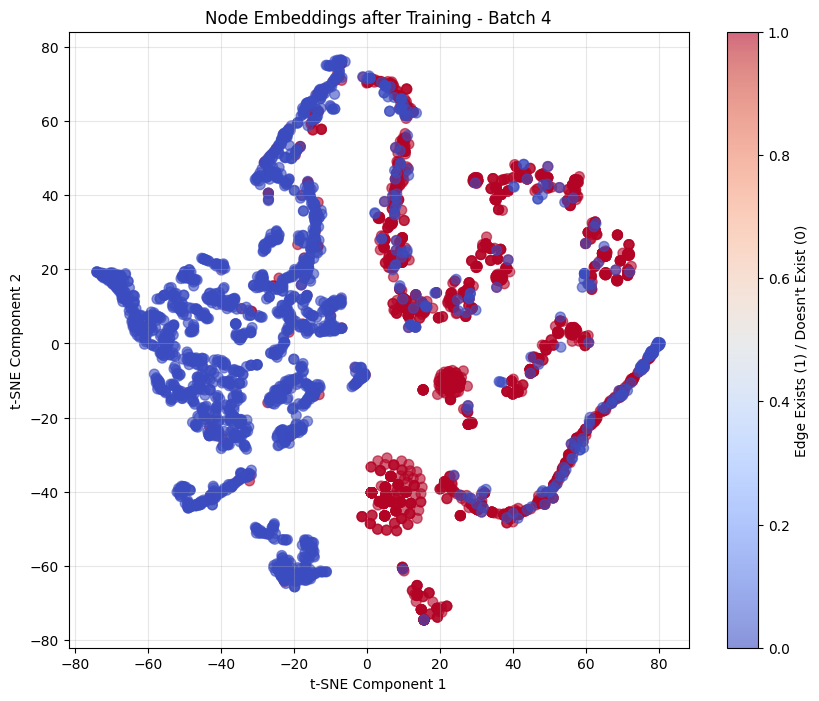

Average similarity for positive pairs: 0.9392
Average similarity for negative pairs: 0.0865
Separation (pos - neg): 0.8528


In [ ]:
for i, sample_batch in enumerate(temporal_batches[0:4]):
    title = f"Node Embeddings after Training - Batch {i+1}"
    visualize_embeddings(model, sample_batch, node_feats, title=title)

In [ ]:
len(temporal_batches)

2705

In [ ]:
edge_lookup = {}
for _, row in edges_train.iterrows():

    key = (row['src_id'], row['dst_id'], row['edge_type'])
    if key not in edge_lookup:
        edge_lookup[key] = []
    edge_lookup[key].append(row['timestamp'])

    key_rev = (row['dst_id'], row['src_id'], row['edge_type'])
    if key_rev not in edge_lookup:
        edge_lookup[key_rev] = []
    edge_lookup[key_rev].append(row['timestamp'])

In [ ]:
def visualize_prediction_results(model, test_data, node_feats, edge_features, ground_truth, predictions,
                               threshold=0.5, max_links=100, title="Link Prediction Results"):

    pred_labels = [1 if p > threshold else 0 for p in predictions]

    true_positive_indices = [i for i, (gt, pred) in enumerate(zip(ground_truth, pred_labels))
                           if gt == 1 and pred == 1]

    false_negative_indices = [i for i, (gt, pred) in enumerate(zip(ground_truth, pred_labels))
                            if gt == 1 and pred == 0]

    false_positive_indices = [i for i, (gt, pred) in enumerate(zip(ground_truth, pred_labels))
                            if gt == 0 and pred == 1]

    sample_size = max_links // 3

    sampled_indices = []

    if true_positive_indices:
        tp_sample = np.random.choice(true_positive_indices,
                                    min(sample_size, len(true_positive_indices)),
                                    replace=False)
        sampled_indices.extend(tp_sample)

    if false_negative_indices:
        fn_sample = np.random.choice(false_negative_indices,
                                    min(sample_size, len(false_negative_indices)),
                                    replace=False)
        sampled_indices.extend(fn_sample)

    if false_positive_indices:
        fp_sample = np.random.choice(false_positive_indices,
                                    min(sample_size, len(false_positive_indices)),
                                    replace=False)
        sampled_indices.extend(fp_sample)

    if not sampled_indices:
        print("No links to visualize.")
        return

    G = nx.Graph()

    for idx in sampled_indices:
        src = test_data.iloc[idx]['src_id']
        dst = test_data.iloc[idx]['dst_id']
        prob = predictions[idx]
        gt = ground_truth[idx]
        pred = pred_labels[idx]

        if gt == 1 and pred == 1:
            pred_type = "true_positive"
        elif gt == 1 and pred == 0:
            pred_type = "false_negative"
        elif gt == 0 and pred == 1:
            pred_type = "false_positive"
        else:
            pred_type = "true_negative"

        G.add_edge(src, dst,
                  weight=prob,
                  probability=f"{prob:.2f}",
                  ground_truth=gt,
                  prediction=pred,
                  pred_type=pred_type)

    edge_list = list(G.edges())
    if not edge_list:
        print("No edges to visualize.")
        return

    src_nodes = [e[0] for e in edge_list]
    dst_nodes = [e[1] for e in edge_list]

    all_src = np.array(src_nodes + dst_nodes)
    all_dst = np.array(dst_nodes + src_nodes)

    edge_index = torch.tensor(
        np.array([all_src, all_dst]),
        dtype=torch.long
    )

    model.eval()
    with torch.no_grad():
        edge_attr = torch.zeros(len(all_src), edge_features.shape[1]-1)

        mean_time = test_data['start_time'].mean()
        timestamps = torch.tensor([mean_time], dtype=torch.float)

        node_embeddings = model(
            node_feats,
            edge_index,
            edge_attr,
            timestamps
        )

    plt.figure(figsize=(14, 12))


    pos = nx.spring_layout(G, seed=42)


    node_colors = []
    for node in G.nodes():
        if node < len(node_embeddings):
            node_colors.append(node_embeddings[node][0].item())
        else:
            node_colors.append(0)

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        node_size=150,
        alpha=0.8
    )

    edge_colors = []
    edge_widths = []

    for u, v, data in G.edges(data=True):
        pred_type = data['pred_type']
        if pred_type == "true_positive":
            edge_colors.append('green')
            edge_widths.append(2.0)
        elif pred_type == "false_negative":
            edge_colors.append('red')
            edge_widths.append(1.5)
        elif pred_type == "false_positive":
            edge_colors.append('orange')
            edge_widths.append(1.5)
        else:
            edge_colors.append('blue')
            edge_widths.append(1.0)

    edges = nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.7
    )

    high_conf_edges = {(u, v): f"{G[u][v]['probability']}"
                      for u, v in G.edges()
                      if float(G[u][v]['probability']) > 0.8 or float(G[u][v]['probability']) < 0.2}

    if len(high_conf_edges) < 50:
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=high_conf_edges,
            font_size=8
        )

    if len(G.nodes()) < 50:
        nx.draw_networkx_labels(G, pos, font_size=8)
    else:
        degrees = dict(G.degree())
        top_nodes = {node: str(node) for node, degree in degrees.items()
                    if degree > np.percentile(list(degrees.values()), 75)}
        nx.draw_networkx_labels(G, pos, labels=top_nodes, font_size=8)

    plt.colorbar(nodes, label="Node Embedding Value")

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=2, label='True Positive (Correct Link)'),
        Line2D([0], [0], color='red', lw=2, label='False Negative (Missed Link)'),
        Line2D([0], [0], color='orange', lw=2, label='False Positive (False Link)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(f"{title} (showing {len(G.edges())} links)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    tp = sum(1 for _, _, d in G.edges(data=True) if d['pred_type'] == 'true_positive')
    fn = sum(1 for _, _, d in G.edges(data=True) if d['pred_type'] == 'false_negative')
    fp = sum(1 for _, _, d in G.edges(data=True) if d['pred_type'] == 'false_positive')

    print(f"Visualization Statistics:")
    print(f"Total links shown: {len(G.edges())}")
    print(f"Correctly predicted links (True Positives): {tp}")
    print(f"Missed links (False Negatives): {fn}")
    print(f"Falsely predicted links (False Positives): {fp}")

    total_tp = sum(1 for gt, pred in zip(ground_truth, pred_labels) if gt == 1 and pred == 1)
    total_fn = sum(1 for gt, pred in zip(ground_truth, pred_labels) if gt == 1 and pred == 0)
    total_fp = sum(1 for gt, pred in zip(ground_truth, pred_labels) if gt == 0 and pred == 1)

    print(f"\nOverall Model Performance:")
    print(f"Total True Positives: {total_tp}")
    print(f"Total False Negatives: {total_fn}")
    print(f"Total False Positives: {total_fp}")
    if total_tp + total_fn > 0:
        recall = total_tp / (total_tp + total_fn)
        print(f"Recall: {recall:.4f}")
    if total_tp + total_fp > 0:
        precision = total_tp / (total_tp + total_fp)
        print(f"Precision: {precision:.4f}")

In [ ]:
def predict_with_tgn(model, test_data, node_feats, edge_features):
    model.eval()

    test_edge_index = torch.tensor(
        np.array([test_data['src_id'].values, test_data['dst_id'].values]),
        dtype=torch.long
    )

    test_timestamps = torch.tensor((test_data['start_time'].values + test_data['end_time'].values) / 2, dtype=torch.float)

    edge_attr = torch.zeros(len(test_data), edge_features.shape[1]-1)

    with torch.no_grad():
        node_embeddings = model(
            node_feats,
            test_edge_index,
            edge_attr,
            test_timestamps
        )

    results = []
    for i, row in test_data.iterrows():
        src, dst = int(row['src_id']), int(row['dst_id'])

        if src >= len(node_embeddings) or dst >= len(node_embeddings):
            results.append(0)
            continue

        src_emb = node_embeddings[src]
        dst_emb = node_embeddings[dst]
        similarity = F.cosine_similarity(src_emb.unsqueeze(0), dst_emb.unsqueeze(0)).item() * 5.0

        probability = torch.sigmoid(torch.tensor(similarity)).item()
        results.append(probability)

    return results

In [ ]:
def derive_ground_truth(test_data, edges_train):
    print("Code in the derive_ground_truth method...")
    ground_truth = []

    for _, row in test_data.iterrows():
        src, dst, edge_type = row['src_id'], row['dst_id'], row['edge_type']
        start_bin, end_bin = row['start_bin'], row['end_bin']

        key = (src, dst, edge_type)
        if key in edge_lookup:
            exists = any(start_bin <= pd.cut([ts], bins=time_bin_edges, labels=False)[0] <= end_bin
                         for ts in edge_lookup[key] if not pd.isna(pd.cut([ts], bins=time_bin_edges, labels=False)[0]))
        else:
            exists = False

        ground_truth.append(1 if exists else 0)

    return ground_truth

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
model.load_state_dict(torch.load('best_tgat_model.pth'))
model_probs = predict_with_tgn(model, test_data, node_feats, edge_features)
ground_truth = derive_ground_truth(test_data, edges_train)



Code in the derive_ground_truth method...



Results with fixed threshold (0.5):
AUC Score: 0.7110
Accuracy: 0.7650
F1 Score: 0.8655


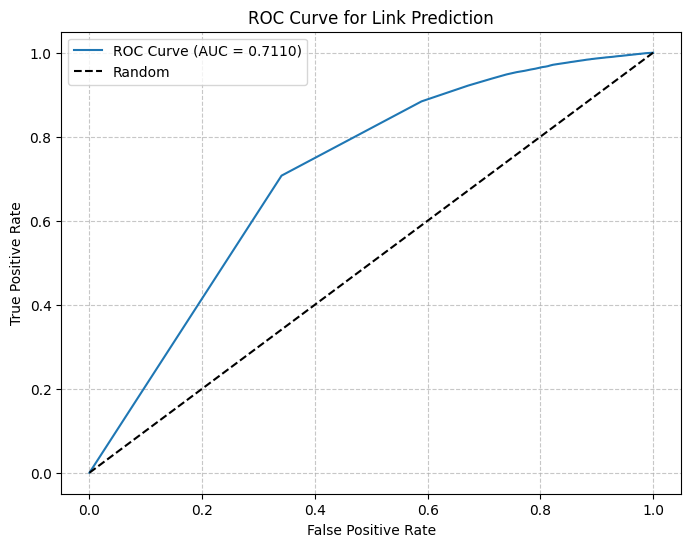

<Figure size 800x600 with 0 Axes>

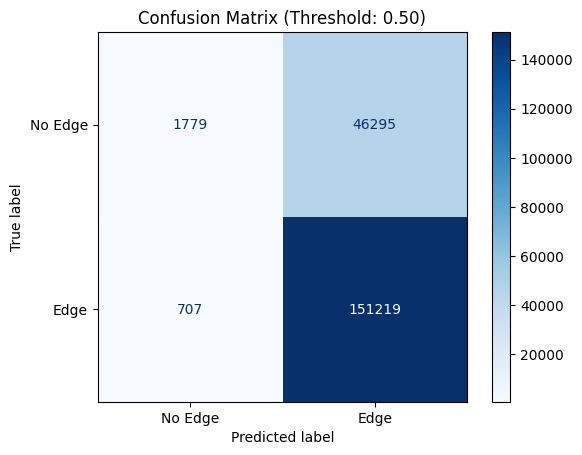

In [ ]:
fixed_threshold = 0.5
final_predictions = [1 if p > fixed_threshold else 0 for p in model_probs]

accuracy = accuracy_score(ground_truth, final_predictions)
f1 = f1_score(ground_truth, final_predictions)
auc = roc_auc_score(ground_truth, model_probs)

results = {
    'threshold': fixed_threshold,
    'auc_score': auc,
    'accuracy': accuracy,
    'f1_score': f1,
    'num_test_samples': len(test_data)
}

print("\nResults with fixed threshold (0.5):")
print(f"AUC Score: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

fpr, tpr, _ = roc_curve(ground_truth, model_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Link Prediction')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

cm = confusion_matrix(ground_truth, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Edge', 'Edge'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold: {fixed_threshold:.2f})')
plt.show()

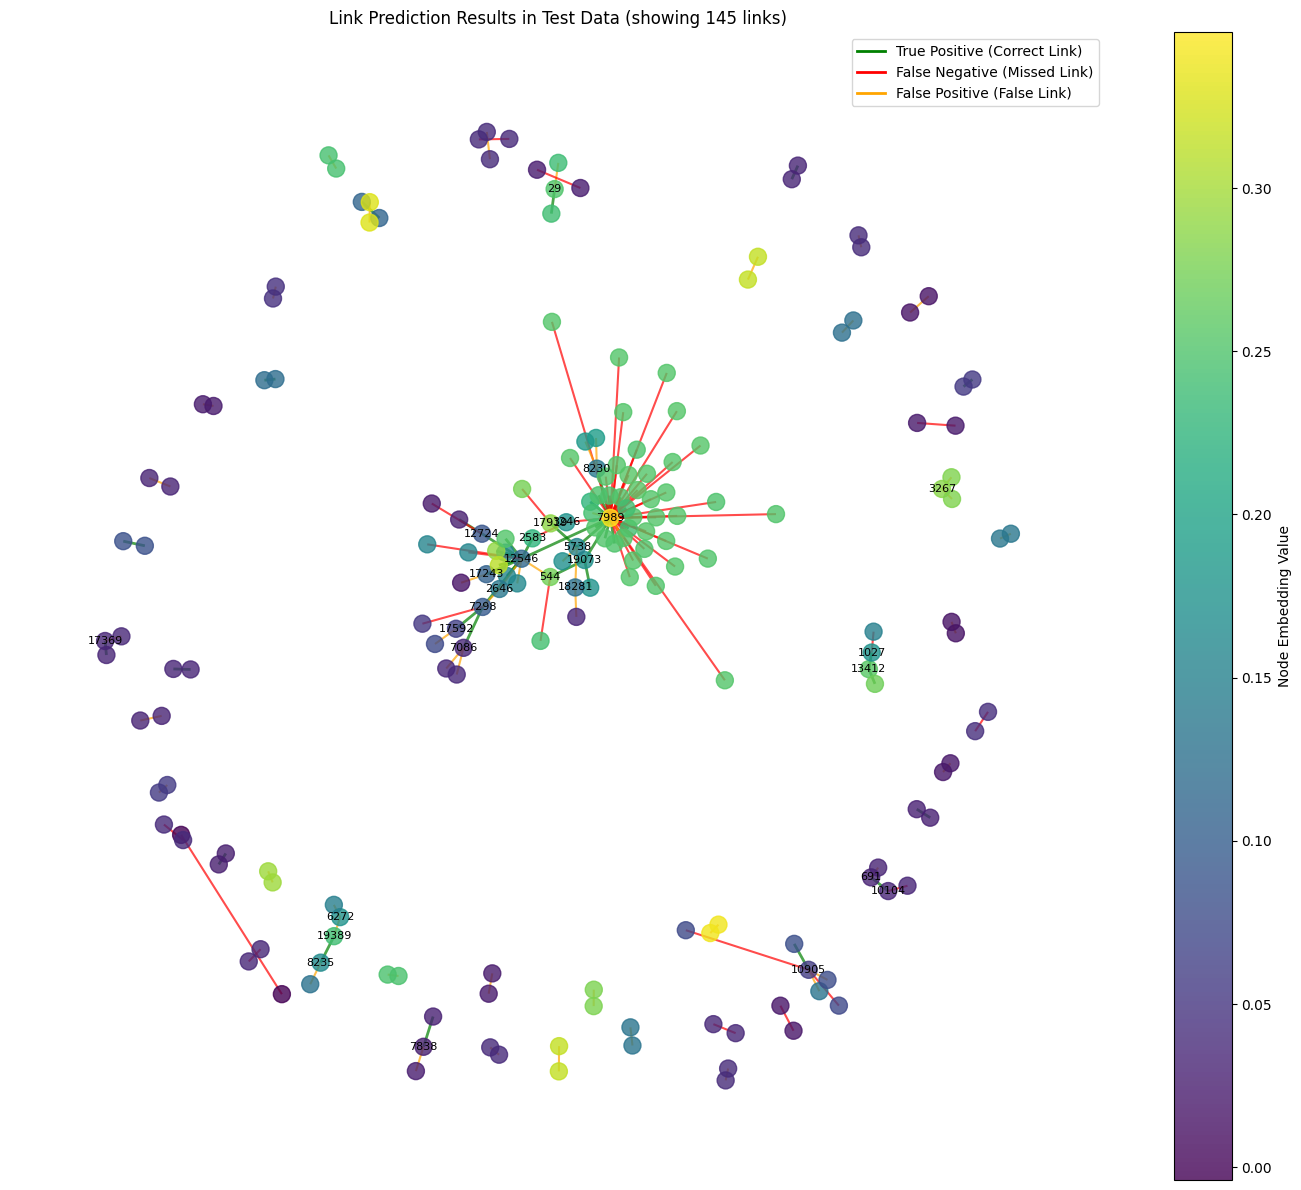

Visualization Statistics:
Total links shown: 145
Correctly predicted links (True Positives): 45
Missed links (False Negatives): 50
Falsely predicted links (False Positives): 50

Overall Model Performance:
Total True Positives: 151219
Total False Negatives: 707
Total False Positives: 46295
Recall: 0.9953
Precision: 0.7656


In [ ]:
visualize_prediction_results(
    model,
    test_data,
    node_feats,
    edge_features,
    ground_truth,
    model_probs,
    threshold=fixed_threshold,
    max_links=150,
    title="Link Prediction Results in Test Data"
)

In [ ]:
from sklearn.metrics import average_precision_score
ap = average_precision_score(ground_truth, model_probs)
print(f"Average Precision: {ap:.4f}")

predictions_df = pd.DataFrame({
    'src_id': test_data['src_id'],
    'dst_id': test_data['dst_id'],
    'edge_type': test_data['edge_type'],
    'predicted_probability': model_probs,
    'predicted_label': final_predictions,
    'ground_truth': ground_truth,
    'correct_prediction': [1 if pred == true else 0 for pred, true in zip(final_predictions, ground_truth)]
})
predictions_df.to_csv('tgn_model_results.csv', index=False)

Average Precision: 0.8522


In [ ]:
assert set(test_data['src_id']).issubset(set(edges_train['src_id'])), "Test nodes not in training set!"

print("Train time range:", edges_train['timestamp'].min(), edges_train['timestamp'].max())
print("Test time range:", test_data['start_time'].min(), test_data['end_time'].max())

Train time range: 1413662400 1494705600
Test time range: 1494581188 1499122550


In [ ]:
train_end_time = edges_train['timestamp'].max()
overlap_ratio = (test_data['start_time'] < train_end_time).mean()
print(f" %{overlap_ratio*100:.2f} of test queries overlap with training time")

 %1.51 of test queries overlap with training time


In [ ]:
clean_test = test_data[test_data['start_time'] >= train_end_time]
clean_probs = predict_with_tgn(model, clean_test, node_feats, edge_features)
clean_truth = derive_ground_truth(clean_test, edges_train)


Code in the derive_ground_truth method...



Temporal Leakage Analysis
Original test size: 200000
Clean test size: 196982 (98.5% of original)
Clean test AUC (no leakage): 0.7139
AUC difference: -0.0029
Accuracy: 0.7684
F1 Score: 0.8677


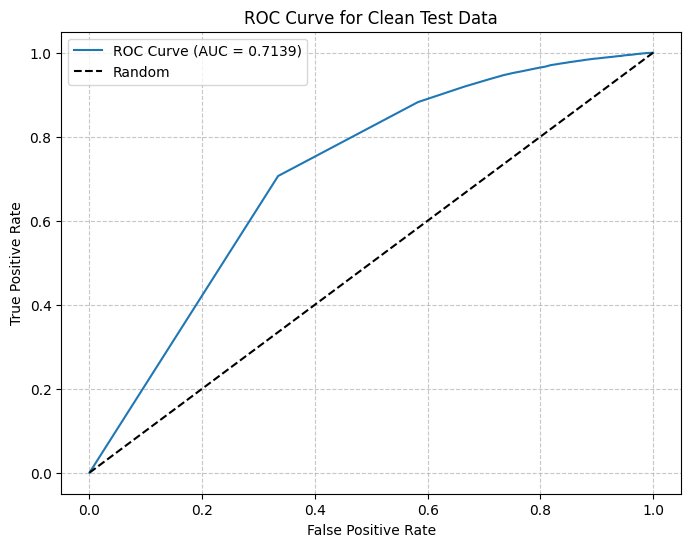

<Figure size 800x600 with 0 Axes>

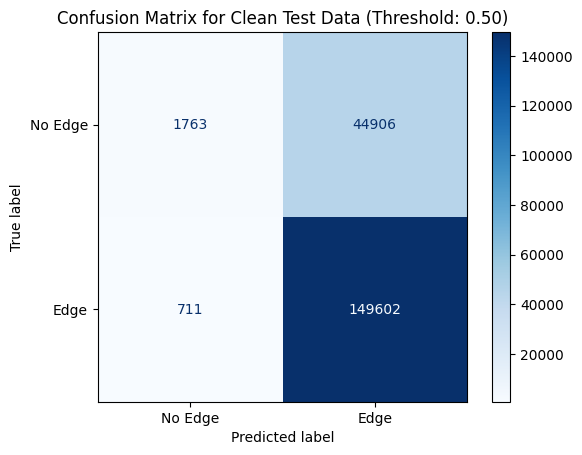

In [ ]:
fixed_threshold_2 = 0.5
final_predictions_2 = [1 if p > fixed_threshold_2 else 0 for p in clean_probs]

clean_auc = roc_auc_score(clean_truth, clean_probs)
f1_2 = f1_score(clean_truth, final_predictions_2)
accuracy_2 = accuracy_score(clean_truth, final_predictions_2)

print("\nTemporal Leakage Analysis")
print(f"Original test size: {len(test_data)}")
print(f"Clean test size: {len(clean_test)} ({len(clean_test)/len(test_data):.1%} of original)")
print(f"Clean test AUC (no leakage): {clean_auc:.4f}")
print(f"AUC difference: {auc-clean_auc:+.4f}")
print(f"Accuracy: {accuracy_2:.4f}")
print(f"F1 Score: {f1_2:.4f}")

fpr, tpr, _ = roc_curve(clean_truth, clean_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {clean_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Clean Test Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

cm = confusion_matrix(clean_truth, final_predictions_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Edge', 'Edge'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for Clean Test Data (Threshold: {fixed_threshold_2:.2f})')
plt.show()


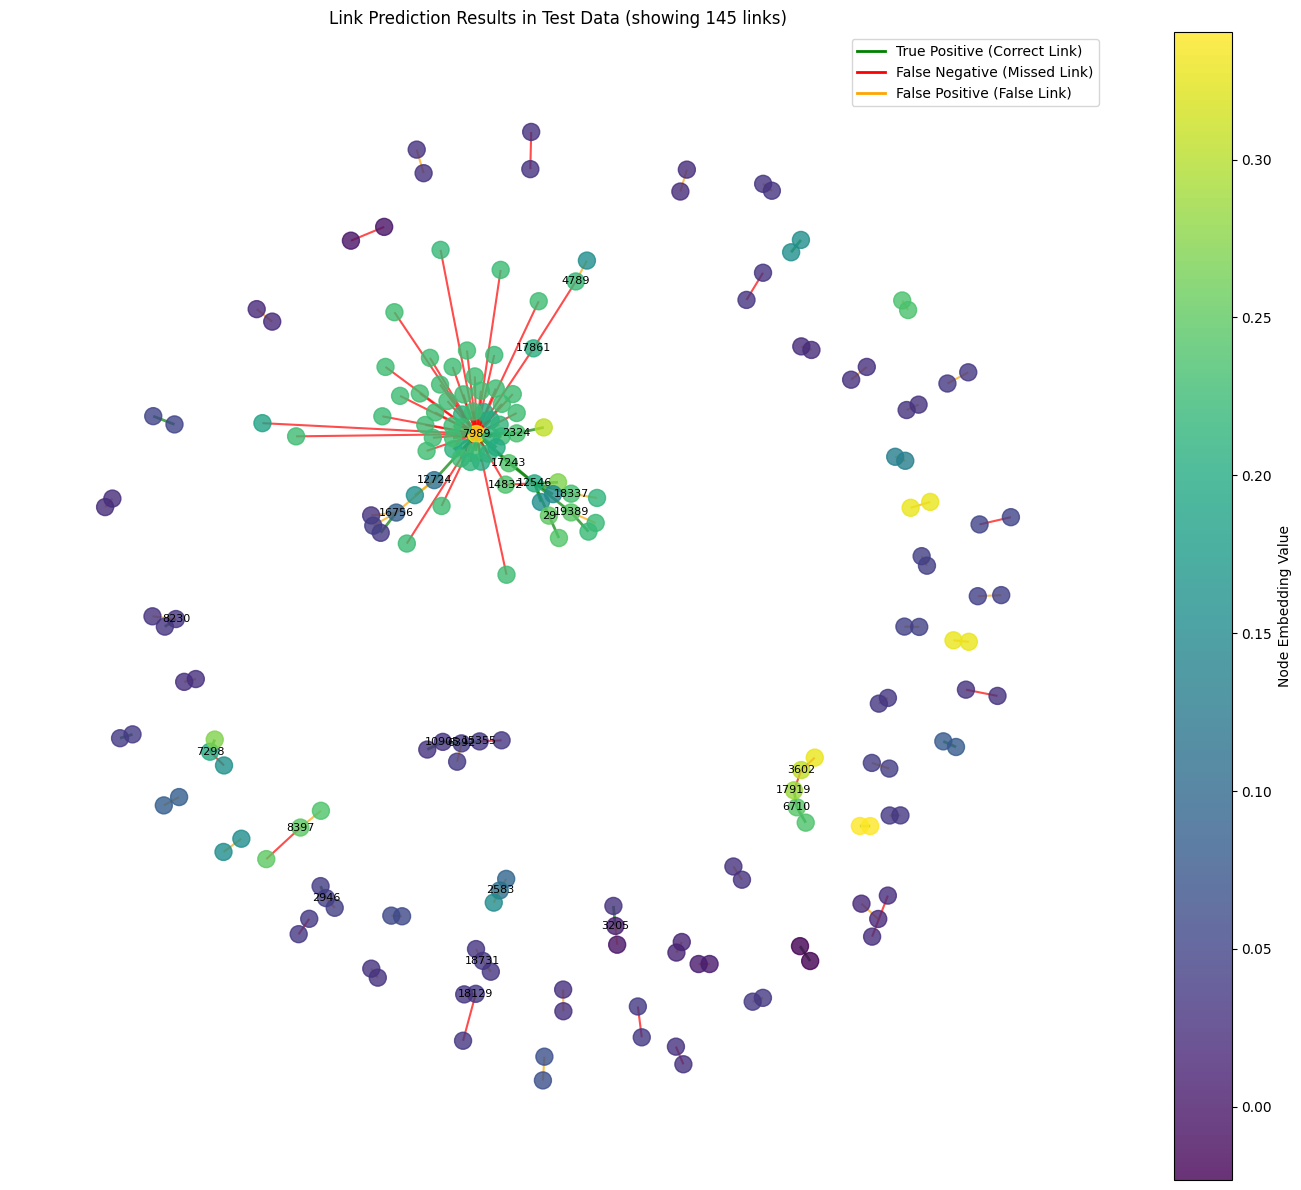

Visualization Statistics:
Total links shown: 145
Correctly predicted links (True Positives): 46
Missed links (False Negatives): 49
Falsely predicted links (False Positives): 50

Overall Model Performance:
Total True Positives: 149602
Total False Negatives: 711
Total False Positives: 44906
Recall: 0.9953
Precision: 0.7691


In [ ]:
visualize_prediction_results(
    model,
    clean_test,
    node_feats,
    edge_features,
    clean_truth,
    clean_probs,
    threshold=fixed_threshold,
    max_links=150,
    title="Link Prediction Results in Test Data"
)

In [ ]:
print("Test data size:", len(test_data))

Test data size: 200000


In [ ]:
predictions_df_2 = pd.DataFrame({
    'src_id': clean_test['src_id'],
    'dst_id': clean_test['dst_id'],
    'edge_type': clean_test['edge_type'],
    'predicted_probability': clean_probs,
    'predicted_label': final_predictions_2,
    'ground_truth': clean_truth,
    'correct_prediction': [1 if pred == true else 0 for pred, true in zip(final_predictions_2, clean_truth)]
})
predictions_df_2.to_csv('output_A_clean_tgn.csv', index=False, header=False)
